# Student Grade Regression - Portuguese - LightGBM

## Import base libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data preprocessing

In [2]:
# df = pd.read_csv('student-mat.csv')  # Math class
df = pd.read_csv('student-por.csv')  # Portuguese class
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

print(X.shape, y.shape)

(649, 32) (649,)


In [3]:
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

In [4]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [5]:
# Identify all categorical columns
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,no,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,no,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,no,no,yes,yes,no,no


In [6]:
# Identify all numerical columns
obj_df = df.select_dtypes(include=['int64']).copy()
obj_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,18,4,4,2,2,0,4,3,4,1,1,3,4,0,11,11
1,17,1,1,1,2,0,5,3,3,1,1,3,2,9,11,11
2,15,1,1,1,2,0,4,3,2,2,3,3,6,12,13,12
3,15,4,2,1,3,0,3,2,2,1,1,5,0,14,14,14
4,16,3,3,1,2,0,4,3,2,1,2,5,0,11,13,13


In [7]:
# Check for missing values
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [8]:
# Categorical Columns (indices) - 0:1, 3:5, 8:11, 15:22
from sklearn.preprocessing import LabelEncoder

# Label Encode - 0:1, 3:5, 15:22
le = LabelEncoder()
# le_columns = X[:, [0, 1, 3, 4, 5, 15, 16, 17, 18, 19, 20, 21, 22]]

# for i in X[:]:
#   if i in le_columns:
#     X[:, i] = le.fit_transform(X[:, i])

# Encode nominal attributes
X[:, 0] = le.fit_transform(X[:, 0])
X[:, 1] = le.fit_transform(X[:, 1])
X[:, 3] = le.fit_transform(X[:, 3])
X[:, 4] = le.fit_transform(X[:, 4])
X[:, 5] = le.fit_transform(X[:, 5])
X[:, 8] = le.fit_transform(X[:, 8])
X[:, 9] = le.fit_transform(X[:, 9])
X[:, 10] = le.fit_transform(X[:, 10])
X[:, 11] = le.fit_transform(X[:, 11])

# Encode binary attributes
X[:, 15] = le.fit_transform(X[:, 15])
X[:, 16] = le.fit_transform(X[:, 16])
X[:, 17] = le.fit_transform(X[:, 17])
X[:, 18] = le.fit_transform(X[:, 18])
X[:, 19] = le.fit_transform(X[:, 19])
X[:, 20] = le.fit_transform(X[:, 20])
X[:, 21] = le.fit_transform(X[:, 21])
X[:, 22] = le.fit_transform(X[:, 22])

print(X)

[[0 0 18 ... 4 0 11]
 [0 0 17 ... 2 9 11]
 [0 0 15 ... 6 12 13]
 ...
 [1 0 18 ... 6 11 12]
 [1 1 17 ... 6 10 10]
 [1 1 18 ... 4 10 11]]


In [9]:
# Split dataframe (df) into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

In [10]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [11]:
# Apply PCA (dimensionality reduction)
# from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

## Define LightGBM model

In [12]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

reg = LGBMRegressor(max_depth=3, n_estimators=32, learning_rate=0.1,
                    num_leaves=7, min_split_gain=2, max_samples=0.01,
                    reg_lambda=2.11, subsample=1, subsample_freq=1,
                    colsample_bytree=0.94, random_state=0)
reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.94,
              importance_type='split', learning_rate=0.1, max_depth=3,
              max_samples=0.01, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=2, n_estimators=32, n_jobs=-1, num_leaves=7,
              objective=None, random_state=0, reg_alpha=0.0, reg_lambda=2.11,
              silent=True, subsample=1, subsample_for_bin=200000,
              subsample_freq=1)

## Evaluate model

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict test set results
y_pred = reg.predict(X_test)
np.set_printoptions(precision = 2)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1 ))
print('')

# Summarize results
print('MAE: %.3f' % (mean_absolute_error(y_test, y_pred)))
print('MSE: %.3f' % (mean_squared_error(y_test, y_pred)))
print('RMSE: %.3f' % (mean_squared_error(y_test, y_pred, squared=False)))
print('R^2 Score: %.3f' % (r2_score(y_test, y_pred)))


[[ 6.43  8.  ]
 [14.79 15.  ]
 [15.92 16.  ]
 [10.71 10.  ]
 [ 9.47 10.  ]
 [12.8  12.  ]
 [13.3  13.  ]
 [17.34 17.  ]
 [12.44 12.  ]
 [11.46 12.  ]
 [10.87 11.  ]
 [10.55 10.  ]
 [13.06 13.  ]
 [ 8.76  8.  ]
 [17.34 18.  ]
 [12.69 12.  ]
 [13.1  13.  ]
 [12.89 13.  ]
 [10.73 10.  ]
 [10.64 10.  ]
 [12.8  12.  ]
 [10.61 10.  ]
 [17.34 17.  ]
 [13.19 15.  ]
 [12.61 14.  ]
 [ 3.89  0.  ]
 [12.77 12.  ]
 [13.27 14.  ]
 [11.21 12.  ]
 [12.67  9.  ]
 [13.4  13.  ]
 [16.17 16.  ]
 [12.77 13.  ]
 [15.78 16.  ]
 [12.82 12.  ]
 [ 8.97 10.  ]
 [ 9.42 10.  ]
 [11.1  11.  ]
 [12.73 13.  ]
 [10.6  10.  ]
 [15.46 15.  ]
 [17.25 18.  ]
 [11.21 11.  ]
 [13.17 13.  ]
 [12.61 13.  ]
 [10.03 10.  ]
 [12.77 14.  ]
 [10.07  9.  ]
 [11.18 11.  ]
 [ 9.46 10.  ]
 [ 6.39  8.  ]
 [14.86 17.  ]
 [10.04  9.  ]
 [12.44 13.  ]
 [ 6.49  8.  ]
 [10.57 11.  ]
 [11.46 12.  ]
 [11.05 12.  ]
 [14.42 15.  ]
 [14.6  15.  ]
 [13.05 13.  ]
 [ 8.67  7.  ]
 [11.2  12.  ]
 [ 8.97 10.  ]
 [13.04 12.  ]
 [12.8  12.  ]
 [11.35 11

<table border = "1">
  <thead>
    <th colspan = "5">Prediction Scores</th>
  </thead>
  <tbody>
    <tr>
      <td><b>MAE:<b></td>
      <td>0.774</td>
    </tr>
    <tr>
      <td><b>MSE:<b></td>
      <td>1.136</td>
    </tr>
    <tr>
      <td><b>RMSE:<b></td>
      <td>1.066</td>
    </tr>
    <tr>
      <td><b>R^2:<b></td>
      <td>0.840</td>
    </tr>
  </tbody>
</table>

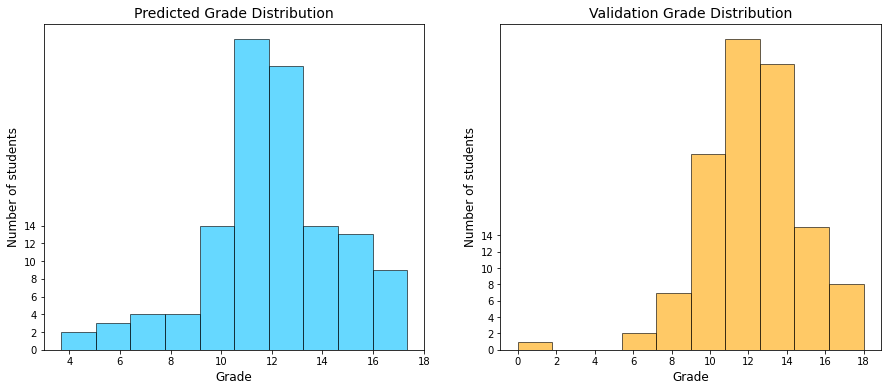

In [14]:
# Plot histogram for y_pred
fig1 = plt.figure(figsize=(15, 6))
ax1 = fig1.add_subplot(1, 2, 1)
plt.xticks(np.arange(0, 20, 2))
plt.yticks(np.arange(0, 16, 2))
plt.hist(x=y_pred, facecolor='deepskyblue', alpha=0.6, edgecolor='black')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Number of students', fontsize=12)
plt.title('Predicted Grade Distribution', fontsize=14)

# Plot histogram for y_test
ax1 = fig1.add_subplot(1, 2, 2)
plt.xticks(np.arange(0, 20, 2))
plt.yticks(np.arange(0, 16, 2))
plt.hist(x=y_test, facecolor='orange', alpha=0.6, edgecolor='black')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Number of students', fontsize=12)
plt.title('Validation Grade Distribution', fontsize=14)

# Show subplot
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 1 --

R^2 Scoring:
Mean: 0.799129
Std: +/- 0.012889
Min: 0.782335
Max: 0.821879

RMSE Scoring:
Mean: 1.501592
Std: +/- 0.056456
Min: 1.402098
Max: 1.577441


-- Fold: 2 --

R^2 Scoring:
Mean: 0.813106
Std: +/- 0.029405
Min: 0.740032
Max: 0.849207

RMSE Scoring:
Mean: 1.444220
Std: +/- 0.100733
Min: 1.308615
Max: 1.683836



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 3 --

R^2 Scoring:
Mean: 0.820453
Std: +/- 0.034215
Min: 0.755152
Max: 0.862957

RMSE Scoring:
Mean: 1.411753
Std: +/- 0.129858
Min: 1.265633
Max: 1.651210



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 4 --

R^2 Scoring:
Mean: 0.827598
Std: +/- 0.040543
Min: 0.768930
Max: 0.892324

RMSE Scoring:
Mean: 1.382683
Std: +/- 0.181202
Min: 1.104154
Max: 1.683605



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)



-- Fold: 5 --

R^2 Scoring:
Mean: 0.835918
Std: +/- 0.059861
Min: 0.705564
Max: 0.914401

RMSE Scoring:
Mean: 1.338916
Std: +/- 0.254331
Min: 0.937556
Max: 1.843679



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 6 --

R^2 Scoring:
Mean: 0.834057
Std: +/- 0.059066
Min: 0.687953
Max: 0.900869

RMSE Scoring:
Mean: 1.346004
Std: +/- 0.245620
Min: 1.027261
Max: 1.934676



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)



-- Fold: 7 --

R^2 Scoring:
Mean: 0.839432
Std: +/- 0.050618
Min: 0.732724
Max: 0.906510

RMSE Scoring:
Mean: 1.325730
Std: +/- 0.243199
Min: 1.061212
Max: 1.857055



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 8 --

R^2 Scoring:
Mean: 0.837616
Std: +/- 0.053452
Min: 0.717966
Max: 0.903137

RMSE Scoring:
Mean: 1.330107
Std: +/- 0.235899
Min: 1.006776
Max: 1.816621



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class


-- Fold: 9 --

R^2 Scoring:
Mean: 0.845247
Std: +/- 0.058930
Min: 0.685376
Max: 0.924468

RMSE Scoring:
Mean: 1.302810
Std: +/- 0.325674
Min: 0.835049
Max: 2.176904



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class


-- Fold: 10 --

R^2 Scoring:
Mean: 0.840751
Std: +/- 0.070635
Min: 0.706313
Max: 0.927524

RMSE Scoring:
Mean: 1.305771
Std: +/- 0.309670
Min: 0.880961
Max: 1.833297



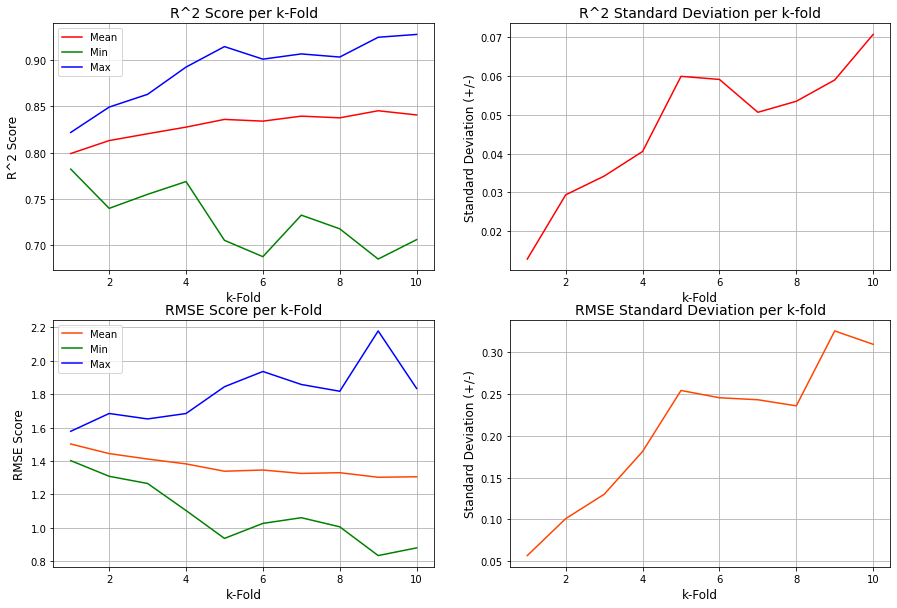

In [15]:
# Apply k-Fold Cross Validation on the training set
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Lists of values
r2_means, r2_stds, r2_mins, r2_maxs = [], [], [], []  # R^2 Scoring
rmse_means, rmse_stds, rmse_mins, rmse_maxs = [], [], [], []  # RMSE Scoring
# Cross validate for 10 k-folds, each with 3 repeats
for k in range(2, 12):
  cv = RepeatedStratifiedKFold(n_splits = k, n_repeats = 3, random_state = 0)
  r2_scores = cross_val_score(reg, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
  # scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  # scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
  rmse_scores = cross_val_score(reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
  
  # Force scores to be positive
  r2_scores = abs(r2_scores)
  rmse_scores = abs(rmse_scores)

  # Print values
  print('')
  print('-- Fold: %d --' % (k-1))
  print('')
  print('R^2 Scoring:')
  print("Mean: %f" % (np.mean(r2_scores)))
  print("Std: +/- %f" % (np.std(r2_scores)))
  print("Min: %f" % (np.min(r2_scores)))
  print("Max: %f" % (np.max(r2_scores)))
  
  print('')
  print('RMSE Scoring:')
  print("Mean: %f" % (np.mean(rmse_scores)))
  print("Std: +/- %f" % (np.std(rmse_scores)))
  print("Min: %f" % (np.min(rmse_scores)))
  print("Max: %f" % (np.max(rmse_scores)))
  print('')
  
  # Append R^2 scores
  r2_means.append(np.mean(r2_scores))
  r2_stds.append(np.std(r2_scores))
  r2_mins.append(np.min(r2_scores))
  r2_maxs.append(np.max(r2_scores))
  
  # Append RMSE scores
  rmse_means.append(np.mean(rmse_scores))
  rmse_stds.append(np.std(rmse_scores))
  rmse_mins.append(np.min(rmse_scores))
  rmse_maxs.append(np.max(rmse_scores))

# Plot R^2 scores per k-fold:
fig2 = plt.figure(figsize=(15, 10))
ax1 = fig2.add_subplot(2, 2, 1)
ax1.plot(np.arange(1,11), r2_means, color='red', label='Mean')
ax1.plot(np.arange(1,11), r2_mins, color='green', label='Min')
ax1.plot(np.arange(1,11), r2_maxs, color='blue', label='Max')
ax1.set_xlabel('k-Fold', fontsize=12)
ax1.set_ylabel('R^2 Score', fontsize=12)
ax1.set_title('R^2 Score per k-Fold', fontsize=14)
ax1.legend()
ax1.grid(True)

# Plot R^2 Standard Deviations per k-fold:
ax2 = fig2.add_subplot(2, 2, 2)
ax2.plot(np.arange(1,11), r2_stds, color='red')
ax2.set_xlabel('k-Fold', fontsize=12)
ax2.set_ylabel('Standard Deviation (+/-)', fontsize=12)
ax2.set_title('R^2 Standard Deviation per k-fold', fontsize=14)
ax2.grid(True)

# Plot RMSE scores per k-fold:
ax3 = fig2.add_subplot(2, 2, 3)
ax3.plot(np.arange(1,11), rmse_means, color='orangered', label='Mean')
ax3.plot(np.arange(1,11), rmse_mins, color='green', label='Min')
ax3.plot(np.arange(1,11), rmse_maxs, color='blue', label='Max')
ax3.set_xlabel('k-Fold', fontsize=12)
ax3.set_ylabel('RMSE Score', fontsize=12)
ax3.set_title('RMSE Score per k-Fold', fontsize=14)
ax3.legend()
ax3.grid(True)

# Plot RMSE Standard Deviations per k-fold:
ax4 = fig2.add_subplot(2, 2, 4)
ax4.plot(np.arange(1,11), rmse_stds, color='orangered')
ax4.set_xlabel('k-Fold', fontsize=12)
ax4.set_ylabel('Standard Deviation (+/-)', fontsize=12)
ax4.set_title('RMSE Standard Deviation per k-fold', fontsize=14)
ax4.grid(True)

# Show subplot
plt.show()


<table border = "1">
  <thead>
    <th colspan = "3">Cross-Validation Results</th>
  </thead>
  <tbody>
    <tr>
      <td><b></b></td>
      <td><b>R^2</b></td>
      <td><b>RMSE</b></td>
    </tr>
    <tr>
      <td><b>Mean</b></td>
      <td>0.841</td>
      <td>1.306</td>
    </tr>
    <tr>
      <td><b>Std.</b></td>
      <td>0.071</td>
      <td>0.310</td>
    </tr>
    <tr>
      <td><b>Min</b></td>
      <td>0.707</td>
      <td>0.881</td>
    </tr>
    <tr>
      <td><b>Max</b></td>
      <td>0.928</td>
      <td>1.830</td>
    </tr>
  </tbody>
</table>

In [16]:
# Apply Grid Search for parameter tuning
from sklearn.model_selection import GridSearchCV

# param_dict = {'boosting_type': ['gbst'],
#               'max_depth': [10, 25, 50, 75, 100],
#               'n_estimators': [50, 100, 150, 200, 250],
#               'learning_rate': [0.01, 0.05, 0.1, 0.15],
#               'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
#               'num_leaves': [1, 5, 10, 20],
#               'min_split_gain': [2, 5, 10],
#               'max_samples': [0.2, 0.4, 0.6, 0.8, 1],
#               'reg_alpha': [0.5, 1, 1.5, 2, 5, 10],
#               'reg_lambda': [0.5, 1, 1.5, 2, 5, 10],
#               'subsample': [1, 1.5, 2, 5, 10],
#               'subsample_freq': [5, 10, 15, 20, 25],
#               'random_state': [0, 1, 2, 5, 10, 20, 40]}


# R2 scoring
param_dict = {'boosting_type': ['gbdt'],
              'max_depth': [3],
              'n_estimators': [32],
              'colsample_bytree': [0.94],
              'learning_rate': [0.1],
              'num_leaves': [7],
              'min_split_gain': [2],
              'max_samples': [0.01],
              'reg_lambda': [2.11],
              'subsample': [1],
              'subsample_freq': [1],
              'random_state': [0]}

# grid = GridSearchCV(reg, param_dict, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# grid = GridSearchCV(reg, param_dict, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# grid = GridSearchCV(reg, param_dict, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
grid = GridSearchCV(reg, param_dict, scoring='r2', cv=cv, n_jobs=-1)
results = grid.fit(X_train, y_train)

# Summarize results
best_score = grid.best_score_
best_parameters = grid.best_params_
print("Best Score: %.3f%%" % (np.abs(best_score * 100)))  # R^2 Scoring
# print("Best Score: %.3f%%" % (np.abs(best_score)))  # RMSE
print("Best Parameters: ", best_parameters)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)


Best Score: 84.075%
Best Parameters:  {'boosting_type': 'gbdt', 'colsample_bytree': 0.94, 'learning_rate': 0.1, 'max_depth': 3, 'max_samples': 0.01, 'min_split_gain': 2, 'n_estimators': 32, 'num_leaves': 7, 'random_state': 0, 'reg_lambda': 2.11, 'subsample': 1, 'subsample_freq': 1}


<table border = "1">
  <thead>
    <th colspan = "2">Grid Search Results</th>
  </thead>
  <tbody>
    <tr>
      <td><b>Best Score</b></td>
      <td>84.075%</td>
    </tr>
    <tr>
      <td colspan="2"><b>Best Parameters:</b></td>
    </tr>
    <tr>
      <td><b>max_depth</b></td>
      <td>3</td>
    </tr>
    <tr>
      <td><b>n_estimators</b></td>
      <td>33</td>
    </tr>
    <tr>
      <td><b>learning_rate</b></td>
      <td>0.1</td>
    </tr>
    <tr>
      <td><b>colsample_bytree</b></td>
      <td>0.94</td>
    </tr>
    <tr>
      <td><b>num_leaves</b></td>
      <td>7</td>
    </tr>
    <tr>
      <td><b>min_split_gain</b></td>
      <td>2</td>
    </tr>
    <tr>
      <td><b>max_samples</b></td>
      <td>0.01</td>
    </tr>
    <tr>
      <td><b>reg_lambda</b></td>
      <td>2.11</td>
    </tr>
    <tr>
      <td><b>subsample</b></td>
      <td>1</td>
    </tr>
    <tr>
      <td><b>subsample_freq</b></td>
      <td>1</td>
    </tr>
    <tr>
      <td><b>random_state</b></td>
      <td>0</td>
    </tr>
  </tbody>
</table>